In [ ]:
pip install nflfastpy

In [1]:
import nflfastpy as nfl
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

pd.set_option('display.max_columns', 7)

In [3]:
data = pd.concat([nfl.load_pbp_data(season).assign(season=season) for season in range(1999, 2021)])

In [4]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)

# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

# lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

#Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

,team,season,week,...,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2000,1,...,0.269840,0.115978,0.115978
1,ARI,2000,2,...,-0.009200,0.092441,0.092441
2,ARI,2000,4,...,0.283460,0.128136,0.128136
3,ARI,2000,5,...,0.500345,0.197339,0.197339
4,ARI,2000,6,...,0.058499,0.171631,0.171631


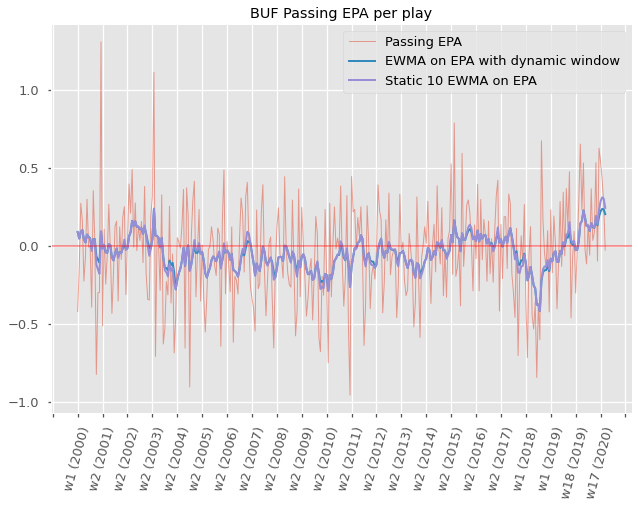

In [6]:
tm = epa.loc[epa['team'] == 'BUF', :].assign(
    season_week = lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
).set_index('season_week')

fig, ax = plt.subplots()

loc = plticker.MultipleLocator(base=16) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='x', rotation=75) #rotate the x-axis labels a bit

ax.plot(tm['epa_shifted_passing_offense'], lw=1, alpha=0.5)
ax.plot(tm['ewma_dynamic_window_passing_offense'], lw=2)
ax.plot(tm['ewma_passing_offense'], lw=2);
plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)

ax.legend(['Passing EPA', 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA'])
ax.set_title('BUF Passing EPA per play')
plt.show();

In [7]:
schedule = data[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]\
.drop_duplicates().reset_index(drop=True)\
.assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))

df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'])\
.merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

df.head()

,season,week,home_team,...,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2000,1,NYG,...,0.269840,0.115978,0.115978
1,2000,1,PIT,...,-0.314740,-0.201637,-0.201637
2,2000,1,WAS,...,-0.368611,0.001226,0.001226
3,2000,1,MIN,...,0.365886,0.105317,0.105317
4,2000,1,LA,...,-0.078273,-0.086851,-0.086851


In [8]:
target = 'home_team_win'
features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]
for feature in features:
  print(feature)

ewma_dynamic_window_rushing_offense_home
ewma_dynamic_window_passing_offense_home
ewma_dynamic_window_rushing_defense_home
ewma_dynamic_window_passing_defense_home
ewma_dynamic_window_rushing_offense_away
ewma_dynamic_window_passing_offense_away
ewma_dynamic_window_rushing_defense_away
ewma_dynamic_window_passing_defense_away


In [9]:
df = df.dropna()

X = df.loc[df['season'] != 2021, features].values
y = df.loc[df['season'] != 2021, target].values

clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [10]:
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))

Model Accuracy: 0.6355992844364937


In [11]:
print('Neg log loss:', np.mean(log_losses))

Neg log loss: -0.6382402354316667


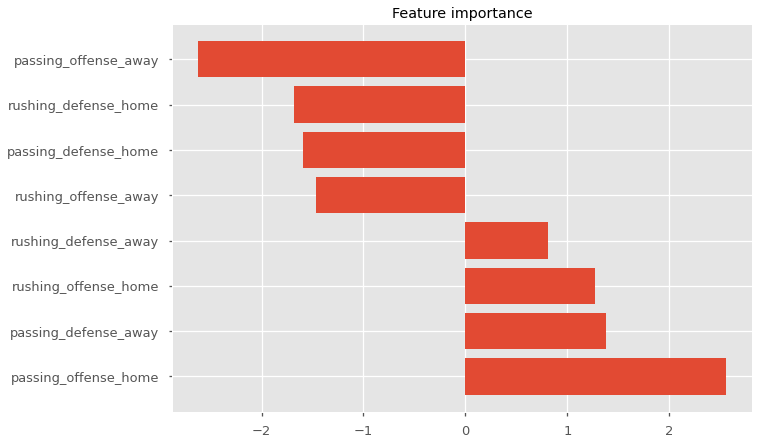

In [12]:
fig, ax = plt.subplots()

feature_names = ['_'.join(feature_name.split('_')[3:]) for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(zip(feature_names, coef_), key=lambda x:x[-1], reverse=True)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title('Feature importance')

ax.barh(features_sorted, coef_sorted);
plt.show();

In [16]:
df_2020 = df.loc[(df['season'] == 2020)].assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
)\
[['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

df_2020['actual_winner'] = df_2020.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
df_2020['predicted_winner'] = df_2020.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df_2020['win_probability'] = df_2020.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
df_2020['correct_prediction'] = (df_2020['predicted_winner'] == df_2020['actual_winner']).astype(int)

df_2020 = df_2020.drop(columns=['home_team_win_probability', 'home_team_win'])

df_2020.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(10)

C:\Users\Jesse\Anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\Jesse\Anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,KC,NYJ,8,KC,KC,0.877099,1
1,KC,DEN,13,KC,KC,0.849979,1
2,LA,NYJ,15,LA,NYJ,0.835740,0
3,LA,NYG,4,LA,LA,0.834781,1
4,SF,PHI,4,SF,PHI,0.817963,0
5,MIA,NYJ,6,MIA,MIA,0.805536,1
6,KC,CAR,9,KC,KC,0.796249,1
7,BAL,CLE,1,BAL,BAL,0.793379,1
8,BAL,CIN,5,BAL,BAL,0.777116,1
9,IND,JAX,17,IND,IND,0.770575,1


In [17]:
correct = df_2020.loc[df_2020['correct_prediction'] == 1].groupby('week')['correct_prediction'].sum()

num_games = df_2020.groupby('week')['correct_prediction'].size()

results = correct / num_games

results

week
1     0.687500
2     0.875000
3     0.500000
4     0.733333
5     0.714286
6     0.500000
7     0.714286
8     0.571429
9     0.500000
10    0.714286
11    0.642857
12    0.687500
13    0.466667
14    0.562500
15    0.687500
16    0.687500
17    0.750000
18    0.666667
19    0.750000
20    0.500000
21    1.000000
Name: correct_prediction, dtype: float64

In [18]:
print(df_2020.loc[df_2020['week'] == results.idxmax()].sort_values(by='win_probability', ascending=False))

     home_team away_team  week predicted_winner actual_winner  \
5590        TB        KC    21               TB            TB   

      win_probability  correct_prediction  
5590         0.571679                   1  


In [19]:
df_2020.loc[df_2020['week'] > 17]

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
5578,TEN,BAL,18,BAL,BAL,0.566298,1
5579,NO,CHI,18,NO,NO,0.753424,1
5580,PIT,CLE,18,PIT,CLE,0.511604,0
5581,BUF,IND,18,BUF,BUF,0.629355,1
5582,SEA,LA,18,SEA,LA,0.587599,0
5583,WAS,TB,18,TB,TB,0.621212,1
5584,BUF,BAL,19,BUF,BUF,0.518606,1
5585,KC,CLE,19,KC,KC,0.581925,1
5586,GB,LA,19,GB,GB,0.691323,1
5587,NO,TB,19,NO,TB,0.593380,0


In [20]:
pip install itertools

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [21]:
import itertools

def ewma(data, window):
    """
    Calculate the most recent value for EWMA given an array of data and a window size
    """
    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    scale = 1 / alpha_rev
    n = data.shape[0]
    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0] * alpha_rev**(r+1)
    pw0 = alpha * alpha_rev**(n-1)
    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out[-1]

data_2020 = data.loc[(data['season'] == 2020)]
offense = data_2020.loc[(data_2020['posteam'] == 'KC') | (data_2020['posteam'] == 'TB')]
defense = data_2020.loc[(data_2020['defteam'] == 'KC') | (data_2020['defteam'] == 'TB')]

rushing_offense = offense.loc[offense['rush_attempt'] == 1]\
.groupby(['posteam', 'week'], as_index=False)['epa'].mean().rename(columns={'posteam': 'team'})
passing_offense = offense.loc[offense['pass_attempt'] == 1]\
.groupby(['posteam', 'week'], as_index=False)['epa'].mean().rename(columns={'posteam': 'team'})
rushing_defense = defense.loc[defense['rush_attempt'] == 1]\
.groupby(['defteam', 'week'], as_index=False)['epa'].mean().rename(columns={'defteam': 'team'})
passing_defense = defense.loc[defense['pass_attempt'] == 1]\
.groupby(['defteam', 'week'], as_index=False)['epa'].mean().rename(columns={'defteam': 'team'})

super_bowl_X = np.zeros(8)

for i, (tm, stat_df) in enumerate(itertools.product(['KC', 'TB'], [rushing_offense, passing_offense, rushing_defense, passing_defense])):
    ewma_value = ewma(stat_df.loc[stat_df['team'] == tm]['epa'].values, 20)
    super_bowl_X[i] = ewma_value

predicted_winner = clf.predict(super_bowl_X.reshape(1, 8))[0]
predicted_proba = clf.predict_proba(super_bowl_X.reshape(1, 8))[0]

winner = 'KC' if predicted_winner else 'TB'
win_prob = predicted_proba[-1] if predicted_winner else predicted_proba[0]

print(f'Model predicts {winner} will win the Super Bowl and has a {round(win_prob*100, 2)}% win probability')

Model predicts KC will win the Super Bowl and has a 50.37% win probability
